In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate();

  Activating environment at `~/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/CDC2022-hVB-NARMAX/CDC-2022/Project.toml`


In [2]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using CSV
using DataFrames
using MAT
using JLD
using Parameters
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1342


In [3]:
import ReactiveMP.messageout

In [4]:
data_seed, params_seed = 42, 420

(42, 420)

### Load data

In [5]:
# Read data from CSV file
df = DataFrame(CSV.File("../data/silverbox/SNLS80mV.csv", ignoreemptylines=true))

# Select input and output signals
input = df[:,:V1]
output = df[:,:V2]

# Time horizon
T = length(input);

In [6]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

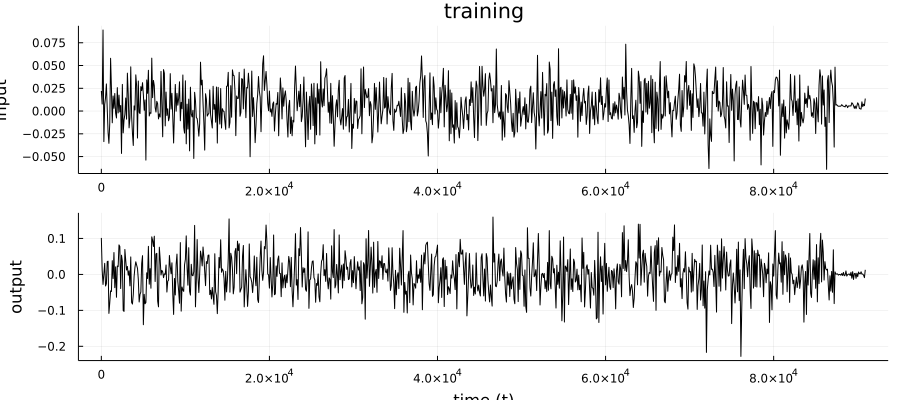

In [7]:
# Plot every n-th time-point to avoid figure size exploding
n = 100
ix = 1:n:T_trn

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

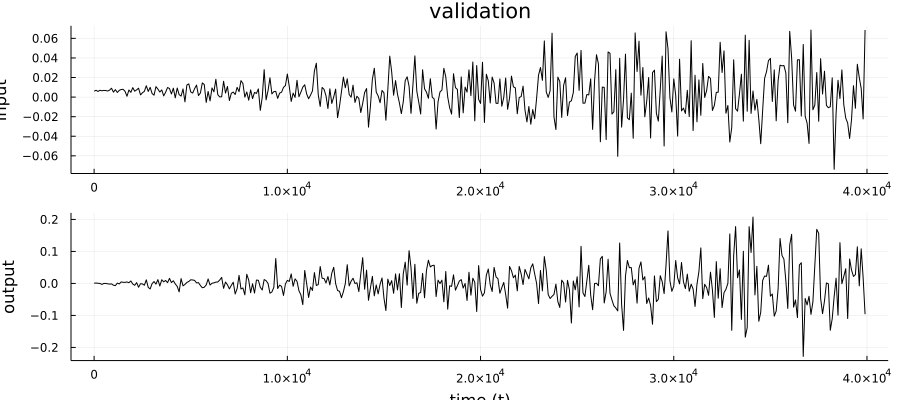

In [10]:
n = 100
ix = 1:n:T_val

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time (t)", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

### Model

In [11]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end

In [12]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    marginal_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [13]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [14]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [15]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h+1); H[full_order-order_h+1:full_order, 2:order_h+1] = diageye(order_h);

In [16]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [17]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    prec = 1e12;
    b = ones(order)/100;
    
    params_flow = model_params[1:end-1]
    params_w    = model_params[end]
    # initialize variables
#     θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order+1), prec*diageye(h_order+1)))}  
    h       = randomvar(n)
    e       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order)) # default: FlowMeta(model, Linearization())
    
    AR_meta = ARMeta(Multivariate, h_order+1, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
#     w   ~ GammaShapeRate(1.0, 1.0)
    
    S = shift(order_h+1);
    c = zeros(order_h+1); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        h[t] ~ MvNormalMeanPrecision(S*h_prev, melu(params_w)*c*c' + diageye(order_h+1)*prec)
        
#         h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        
        y_nodes[t], y[t] ~ y_lat_2[t] + dot(h[t], c)
        h_prev = h[t]
    end

#     return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w
    return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [18]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order+1), 0.1*diageye(h_order+1)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                        observations_prev, controls,
                                                                        y_order, u_order, h_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    
#     setmarginal!(w, GammaShapeRate(1.0, 1.0))
#     setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [19]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

### Prepare data

In [20]:
train_size = 800
test_size = 1000

# Generate training data
observations_prev, observations = ssm(output_trn, order_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size];

# Generate validation data
observations_prev, observations = ssm(output_val, order_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size], observations[1:test_size], controls[1:test_size];

### Train model

In [21]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; 1.0];

In [22]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=50);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


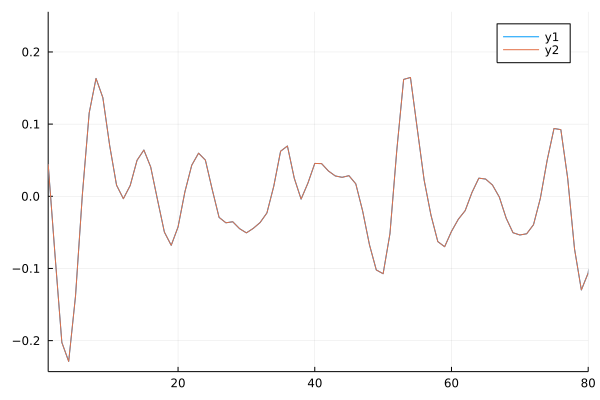

In [23]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

In [24]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=2);
    
    return fe_[end]
end;

In [25]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 50, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

LoadError: MethodError: no method matching Float64(::TinyNumber)
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:760
[0m  (::Type{T})([91m::VectorizationBase.Double{T}[39m) where T<:Union{Float16, Float32, Float64, VectorizationBase.Vec{var"#s33", var"#s32"} where {var"#s33", var"#s32"<:Union{Float16, Float32, Float64}}, VectorizationBase.VecUnroll{var"#s31", var"#s30", var"#s29", V} where {var"#s31", var"#s30", var"#s29"<:Union{Float16, Float32, Float64}, V<:Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit, VectorizationBase.AbstractSIMD{var"#s30", var"#s29"}}}} at /home/wmkouw/.julia/packages/VectorizationBase/xtnDY/src/special/double.jl:84
[0m  ...

In [26]:
inf_params = Optim.minimizer(res)

LoadError: UndefVarError: res not defined

In [27]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=50);

LoadError: UndefVarError: inf_params not defined

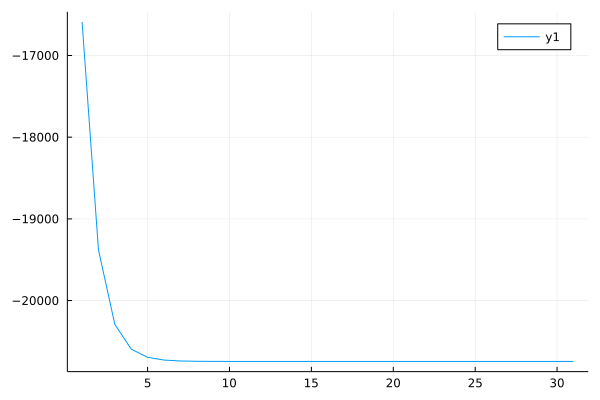

In [28]:
plot(fe_[20:50])

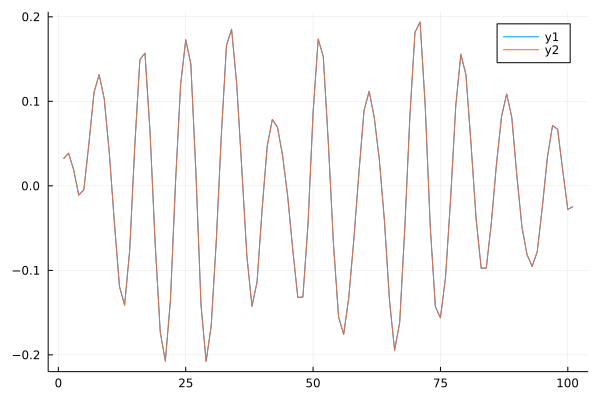

In [29]:
from, to = 100, 200
plot(mean.(y_out_[from:to]), ribbon=sqrt.(cov.(y_out_[from:to])))
plot!(Y_train[from:to])

In [30]:
mean.(h_)

800-element Vector{Vector{Float64}}:
 [0.1476582073531634, -1.508427683264709e-7, -1.2235743828356754e-7]
 [0.020463236055630236, 0.1476581967958274, -1.5195337172915318e-7]
 [-0.08205233947679508, 0.0204632229249352, 0.14765819267121208]
 [-0.08781171738014468, -0.08205235440824299, 0.020463217852934635]
 [0.0076190063118653515, -0.08781173146523924, -0.08205235935957776]
 [0.137013032153199, 0.007618994973019474, -0.08781173564382776]
 [0.22637852129944494, 0.13701302437226112, 0.007618991983754241]
 [0.24772522202824362, 0.22637851682325102, 0.1370130225779528]
 [0.20523447786479712, 0.24772521939938574, 0.22637851591288682]
 [0.1369200699617223, 0.20523447483125706, 0.2477252185773211]
 [0.08945350269663761, 0.1369200652361778, 0.20523447345235354]
 [0.08069623897930332, 0.08945349649723774, 0.13692006327488468]
 [0.10565681578498627, 0.08069623221678979, 0.08945349422793787]
 ⋮
 [0.11602562414185856, 0.14260569270803175, 0.14903589083108854]
 [0.09247977893812614, 0.11602561691151

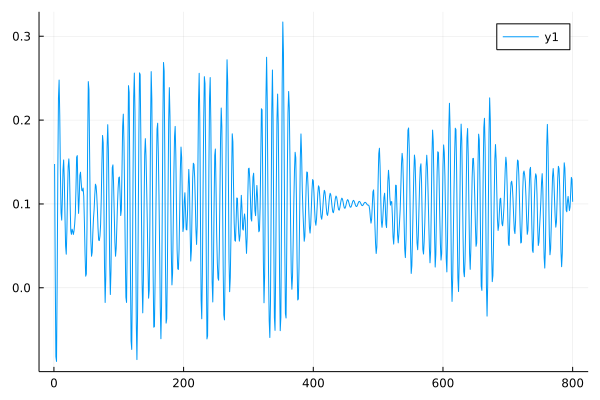

In [31]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [32]:
cov.(h_)

800-element Vector{Matrix{Float64}}:
 [4.3572487862163026e-14 0.0 -0.0; 0.0 4.999999971553377e-13 -2.8449311410180534e-21; -0.0 -2.8449311410180534e-21 9.999999971543e-13]
 [4.386873441061844e-14 0.0 -0.0; 0.0 4.999999972182878e-13 -2.781968248600636e-21; -0.0 -2.781968248600636e-21 9.999999972172755e-13]
 [4.365497182995757e-14 0.0 -0.0; 0.0 4.999999962428375e-13 -3.757504507319708e-21; -0.0 -3.757504507319708e-21 9.999999962416534e-13]
 [4.316781479710108e-14 0.0 -0.0; 0.0 4.999999951264188e-13 -4.8738694737048045e-21; -0.0 -4.8738694737048045e-21 9.999999951253418e-13]
 [4.3909896473647264e-14 0.0 -0.0; 0.0 4.999999948694988e-13 -5.130765678708871e-21; -0.0 -5.130765678708871e-21 9.999999948684697e-13]
 [4.410622310481526e-14 0.0 -0.0; 0.0 4.999999954635875e-13 -4.536726887288592e-21; -0.0 -4.536726887288592e-21 9.999999954624583e-13]
 [4.435813056599697e-14 0.0 -0.0; 0.0 4.999999967536047e-13 -3.246717310776635e-21; -0.0 -3.246717310776635e-21 9.999999967524604e-13]
 [4.40604228766